In [1]:
from model import PModel

import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Global parameters for Pareto front
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 0.005    #Baseline transmission rate

#Parameters for evolutionary simulation
n_loci = 9
n_gens = 15
t = (0, 1000)

In [37]:
#Sample costs and benefits
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

#Initialize model
model = PModel(n_loci, res, cost, beta=beta)
model.normalize()

#Run dynamical simulation
X_t, I_t = model.run_sim(t, n_gens)

#Resample results into time and genotype bins to create a raster
n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, model.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < model.B,model.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals,time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

t_ticks = np.linspace(0, 1, 7)*n_time_bins
t_tick_labels = np.linspace(0, n_gens, 7, dtype=np.uint)

r_ticks = np.linspace(0, 1, 5)*n_res_bins
r_tick_labels = np.linspace(1, 0, 5)

In [4]:
def diversity_panel(n_sims, n_loci=n_loci, epistasis=0, n_gens=n_gens, t=t, beta=beta):
	#Initialize model
	model = PModel(n_loci, np.zeros(n_loci), np.zeros(n_loci), beta=beta)
	
	#Counter variables for the number of monomorphic and polymorphic simulations
	n_mono = 0
	n_poly = 0

	shannon_div = np.zeros(n_sims)

	for i in range(n_sims):
		#Sample costs and benefits
		cost = np.random.exponential(0.1, n_loci)
		res = np.random.exponential(0.1, n_loci)

		#Update model parameters and add epistasis
		model.update_loci(res, cost)
		if epistasis == 1:
			model.add_epistasis(2, p1, sigma1)
		elif epistasis == 2:
			model.add_epistasis(2, p1, sigma1)
			model.add_epistasis(3, p2, sigma2)

		model.normalize()

		#Run dynamical simulation
		X_t, _ = model.run_sim(t, n_gens)

		#Check for polymorphism and update counters
		if np.sum(X_t[:, -1] > 5) > 1:
			n_poly += 1
		else:
			n_mono += 1

		#Compute shannon diversity
		eq_prop = X_t[:,-1] / np.sum(X_t[:,-1])
		eq_prop = eq_prop[eq_prop > 0]
		shannon_div[i] = -np.sum(eq_prop*np.log(eq_prop))

	return shannon_div, n_poly/(n_poly+n_mono)

In [5]:
no_epi, prop1 = diversity_panel(100, epistasis=0, n_loci=9)
epi_1, prop2 = diversity_panel(100, epistasis=1, n_loci=9)
epi_2, prop3 = diversity_panel(100, epistasis=2, n_loci=9)

In [6]:
print(prop1, prop2, prop3)

0.27 0.45 0.43


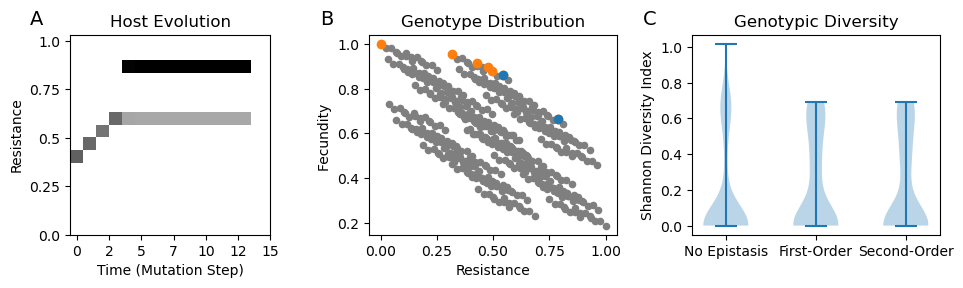

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

genotypes = ax[0].imshow(np.log(1+evol_plot), cmap='Greys')
ax[0].set_title('Host Evolution')
ax[0].set_ylabel('Resistance')
ax[0].set_xlabel('Time (Mutation Step)')
ax[0].set_xticks(t_ticks)
ax[0].set_yticks(r_ticks)
ax[0].set_xticklabels(t_tick_labels)
ax[0].set_yticklabels(r_tick_labels)

abundances = np.max(X_t, axis=1)
ax[1].set_title('Genotype Distribution')
ax[1].set_xlabel('Resistance')
ax[1].set_ylabel('Fecundity ')
ax[1].scatter((1-(model.B/model.beta))[abundances<=1], model.F[abundances<=1], c='tab:gray', s=20)
ax[1].scatter((1-(model.B/model.beta))[abundances>1], model.F[abundances>1], c='tab:orange')
ax[1].scatter((1-(model.B/model.beta))[X_t[:,-1]>1], model.F[X_t[:,-1]>1], c='tab:blue')

ax[2].set_title('Genotypic Diversity')
ax[2].violinplot((no_epi, epi_1, epi_2))
ax[2].set_xticks([1,2,3], ['No Epistasis', 'First-Order', 'Second-Order'])
ax[2].set_ylabel('Shannon Diversity Index')

ax[0].annotate("A", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)
ax[2].annotate("C", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)

plt.tight_layout()

In [8]:
from scipy.stats import f_oneway

f_oneway(no_epi, epi_1, epi_2)

F_onewayResult(statistic=1.5519103257071523, pvalue=0.21355578202970246)